In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np 
from torchvision import transforms
from core.res_unet_plus import ResUnetPlusPlus
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# device = 0
# print(torch.cuda.get_device_name(device))
# torch.cuda.set_device(device)

In [3]:
image_dir = '/proj/kth_deep_pcct/users/x_sarsa/data/'

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
def dataset(image_dir,i,j):
    output_images = []
    input_images = []
    output_images = np.zeros([3,1024,1024])
    input_images = np.zeros([6,1024,1024])
    base_name = 'pht'+str(i)+'pl'+str(j)
    output_images[0] =  transform(np.fromfile(image_dir+'vox_phantoms/'+base_name+'_vox/'+base_name+'.density_1', dtype='float32').reshape(1024,1024))
    output_images[1] =  transform(np.fromfile(image_dir+'vox_phantoms/'+base_name+'_vox/'+base_name+'.density_2', dtype='float32').reshape(1024,1024))
    output_images[2] =  transform(np.fromfile(image_dir+'vox_phantoms/'+base_name+'_vox/'+base_name+'.density_3', dtype='float32').reshape(1024,1024))

    input_images[0] =  transform(np.fromfile(image_dir+'pe_io/'+base_name+'_PeIo_io.raw', dtype='float32').reshape(1024,1024))
    input_images[1] =  transform(np.fromfile(image_dir+'pe_io/'+base_name+'_PeIo_pe.raw', dtype='float32').reshape(1024,1024))
    input_images[2] =  transform(np.fromfile(image_dir+'pe_pvc/'+base_name+'_PePvc_pe.raw', dtype='float32').reshape(1024,1024))
    input_images[3] =  transform(np.fromfile(image_dir+'pe_pvc/'+base_name+'_PePvc_pvc.raw', dtype='float32').reshape(1024,1024))
    input_images[4] =  transform(np.fromfile(image_dir+'pvc_io/'+base_name+'_PvcIo_io.raw', dtype='float32').reshape(1024,1024))
    input_images[5] =  transform(np.fromfile(image_dir+'pvc_io/'+base_name+'_PvcIo_pvc.raw', dtype='float32').reshape(1024,1024))

    return transform(input_images),transform(output_images)

In [29]:
from pytorch_ssim import SSIM
ssim = SSIM(window_size=11, size_average=True)

device = torch.device("cpu")
new_order = (1, 2, 0,3)
path = './checkpoints/evaluate_epoch11_step30.pt'
model = ResUnetPlusPlus(6).to(device)
# model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(path,map_location=device))
model.eval()
results = []
inputs = []
scores = []
gths = []
for j in range(20,25):
    (inp,gth) = dataset(image_dir,1,j)
    gth = torch.unsqueeze(gth,dim=1).permute(new_order).float()
    inp = torch.unsqueeze(inp,dim=1).permute(new_order).float()
    inputs.append(inp)
    gths.append(gth)
    with torch.no_grad():
        pred = model(inp)
    ssim_score = ssim(pred, gth)
    scores.append(ssim_score)
    output  = torch.squeeze(pred,dim = 0)
    results.append(output)

In [30]:
len(gths)

5

In [31]:
scores

[tensor(0.3676),
 tensor(0.3681),
 tensor(0.3679),
 tensor(0.3683),
 tensor(0.3677)]

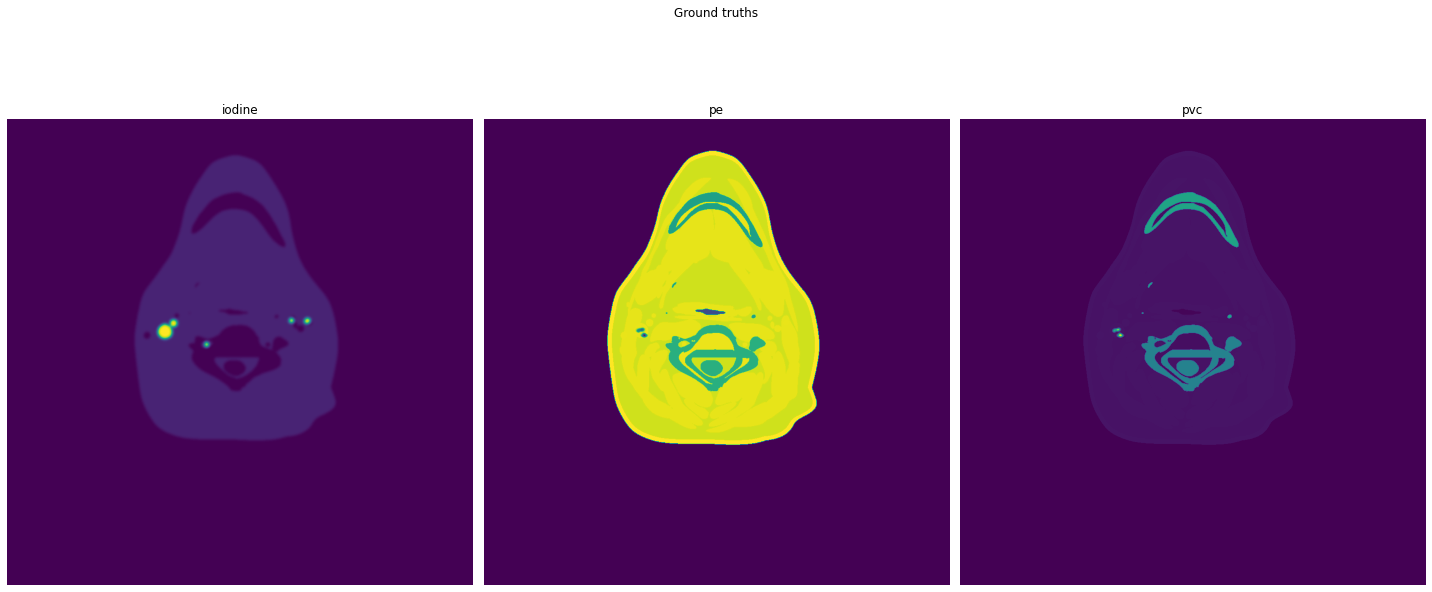

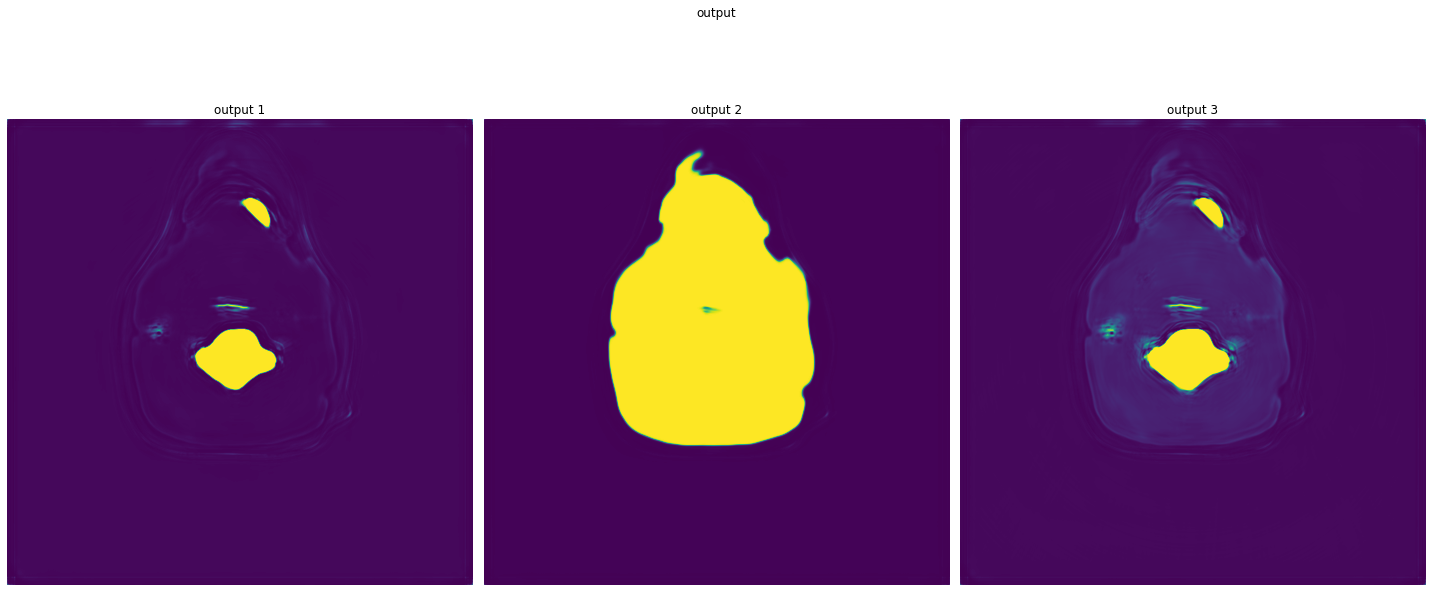

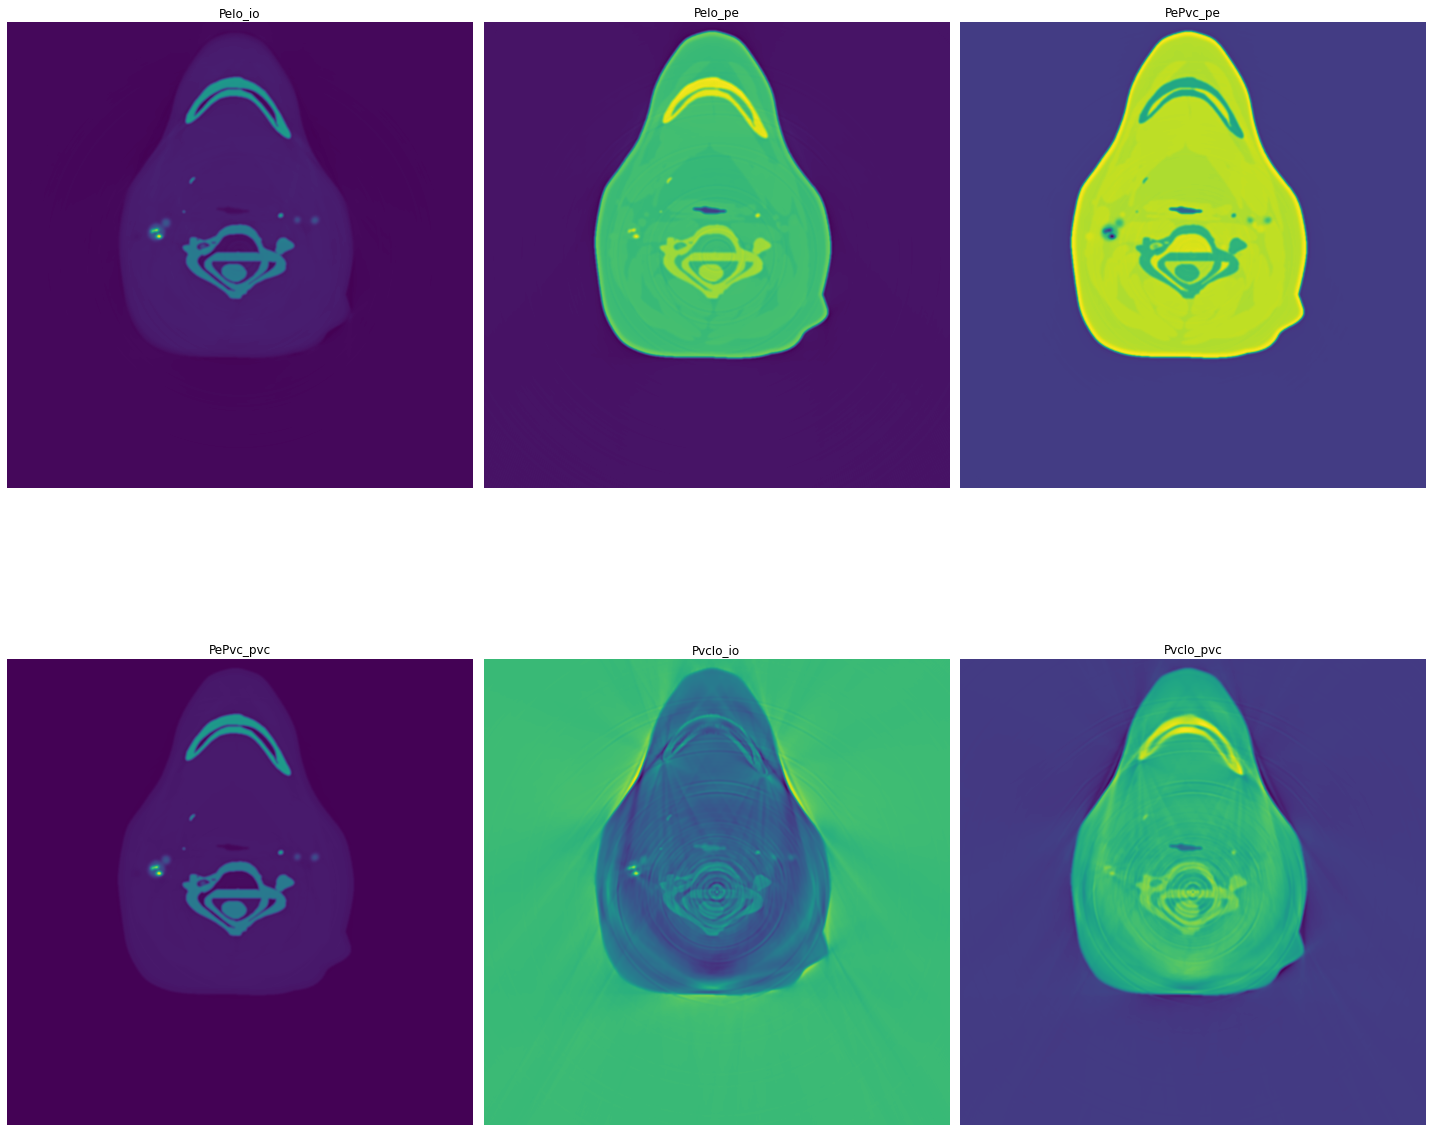

In [32]:
inp_names = ['PeIo_io','PeIo_pe','PePvc_pe','PePvc_pvc','PvcIo_io','PvcIo_pvc']
gth_names = ['iodine','pe','pvc']
fig3, axs = plt.subplots(1,3,figsize=(20, 10))
for j in range(0,5):
    for i in range(0,3):
        gth = torch.squeeze(gths[j],dim=0)[i]
        ax = axs[i] 
        ax.imshow(gth)  # Assuming grayscale images
        ax.axis('off')
        ax.set_title(gth_names[i])
plt.tight_layout()
fig3.suptitle('Ground truths')
plt.show()
fig2, axs = plt.subplots(1,3,figsize=(20, 10))
for j in range(0,5):
    for i in range(0,3):
        output_img = torch.squeeze(results[j],dim=0)[i]
        ax = axs[i] 
        ax.imshow(output_img)  # Assuming grayscale images
        ax.axis('off')
        ax.set_title(f"output {i+1}")
plt.tight_layout()
fig2.suptitle('output')
plt.show()
fig, axs = plt.subplots(2,3,figsize=(20, 20))
for j in range(0,5):
    for i in range(0,6):
        input_img = torch.squeeze(inputs[j],dim=0)[i]
        ax = axs[i//3,i%3] 
        ax.imshow(input_img)  # Assuming grayscale images
        ax.axis('off')
        ax.set_title(inp_names[i])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

In [15]:
# for idx in range(0,6):
#     fig3, axs = plt.subplots(1,3,figsize=(20, 10))
#     for j in range(0,5):
#         for i in range(0,3):
#             gth = torch.squeeze(gths[j],dim=0)[i]
#             ax = axs[i] 
#             ax.imshow(gth)  # Assuming grayscale images
#             ax.axis('off')
#             ax.set_title(gth_names[i])
#     plt.tight_layout()
#     fig3.suptitle('Ground truths')

#     fig2, axs = plt.subplots(1,3,figsize=(20, 10))
#     for j in range(0,5):
#         for i in range(0,3):
#             output_img = torch.squeeze(results[j],dim=0)[i]
#             ax = axs[i] 
#             ax.imshow(output_img)  # Assuming grayscale images
#             ax.axis('off')
#             ax.set_title(f"output {i+1}")
#     plt.tight_layout()
#     fig2.suptitle('output')
#     fig, axs = plt.subplots(2,3,figsize=(20, 20))
#     for j in range(0,5):
#         for i in range(0,6):
#             input_img = torch.squeeze(inputs[j],dim=0)[i]
#             ax = axs[i//3,i%3] 
#             ax.imshow(input_img)  # Assuming grayscale images
#             ax.axis('off')
#             ax.set_title(inp_names[i])
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.tight_layout()
# plt.show()